In [1]:
import warnings
warnings.filterwarnings('ignore')

import argparse
import os, sys, importlib, copy
from glob import glob
import pickle
import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import scipy

from utilities import reduced_parameter as red
from field.electromagnetic import FreeVectorPotential, CavityVectorPotential

from matter.atoms import AtomsInBox
from calculator.calculator import Calculator

from utilities.etc import categorizing_result

import animation as an
import analyze_tools.utils as atu
from analyze_tools.monte_carlo import get_colliding_time

from simulation.single import single_collision_simulation
import utilities.reduced_parameter as red
from utilities.etc import moving_average

plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({'font.size': 12})



Epsilon (erg) 1.6538969109051514e-14
Reduced epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.3825301204819278 ; 1.9116465863453815
CGS epsilon (Ar-Ar, Ar-Xe, Xe-Xe): 1.6538969109051514e-14 ; 2.286562295498387e-14 ; 3.161666383899004e-14
######################
Length multiple - Sigma (cm) 3.41e-08
Reduced sigma (Ar-Ar, Ar-Xe, Xe-Xe): 1.0 ; 1.095307917888563 ; 1.190615835777126
######################
Mass multiples (g) 6.633521465546083e-23
Reduced Mass (Ar, Xe): 1.0 ; 3.286597576849905
######################
Dipole unit multiple (statC . cm) 8.09814943451058e-19
Reduced dipole parameter:
mu0 =  0.08920009870622121
a =  7.8952761266316935
d0 =  1.1018059229945159
d7 =  0.030776244402154505
CGS dipole parameter:
mu0 =  7.223557288960733e-20
a = 2.32E+08
d0 =  3.757158197411299e-08
######################
Time 2.159594587679023e-12
Velocity multiple (cm/s) 15790.00067630667
Temperature  119.79126562255514
######################
c:  1899936.5874009002
Epsilon parameters matrix 
[[1.         1.3825301

In [8]:
0.25 / 3.41

0.07331378299120234

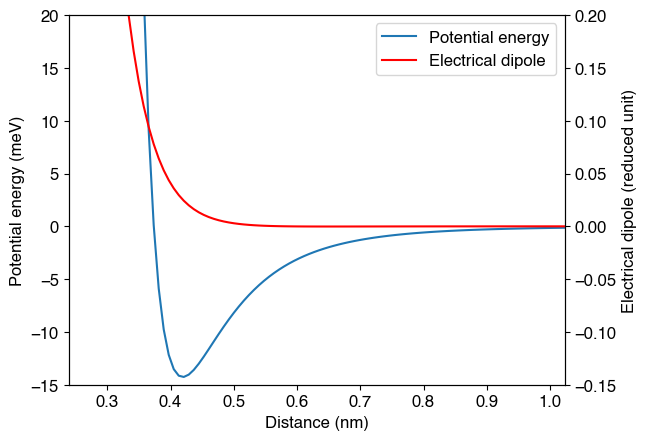

In [34]:
### PLOTTING THE POTENTIAL AND DIPOLE FUNCTION FOR THE PAPER

from calculator.function import LJ_potential, Grigoriev_dipole_

fig, ax = plt.subplots()

x = np.linspace(0.7, 3.0, 100)
pot = red.convert_energy(
    LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, x), 'ev') * 1e3

dipole_func = lambda x: red.mu0 * np.exp(-red.a * (x - red.d0)) - red.d7/x**7
dip = dipole_func(x)

ax.plot(x * red.sigma_ * 1e-1, pot, label = 'Potential energy')
ax.plot([], [], color = 'red', label = 'Electrical dipole')

ax.set_ylim(-15, 20)
ax.set_xlim(min(x * red.sigma_ * 1e-1), max(x * red.sigma_ * 1e-1))
ax.set_ylabel('Potential energy (meV)')
ax.set_xlabel('Distance (nm)')

tax = ax.twinx()

tax.plot(x * red.sigma_ * 1e-1,dip, color = 'red')

tax.set_ylim(-0.15,0.2)
tax.set_ylabel('Electrical dipole (reduced unit)')

ax.legend()

fig.savefig('Miscfig/potential_n_dipole.jpeg', dpi = 600, bbox_inches = 'tight')

In [ ]:
np.random.seed(10) # h = 0.0, T = 135
# h = 0.2, T = 100

Lxy = 3e7; Lz = 3e3
T = 100

atoms = AtomsInBox(
    Lxy = Lxy, Lz = Lz, cell_width = (1e6,1e2), 
    mass_dict = red.mass_dict)

v_ar = np.sqrt((T * red.boltzmann / red.epsilon) )
v_xe = - v_ar / np.sqrt(red.mass_dict['Xe'])

atoms.add(
        elements = ["Ar"],
        r = np.array([[0.0, 0, -5/2]]),
        r_dot = np.array([[0.0, 0.0, v_ar]])# / np.sqrt(2)
        )

atoms.add(
        elements = ["Xe"],
        r = np.array([[0.1,0.0,5/2]]),
        r_dot = np.array([[0.00, 0.00, v_xe]])# / np.sqrt(2)
        )

idxAr = atoms.element_idx(element = "Ar")
idxXe = atoms.element_idx(element = "Xe")
epsilon_mat, sigma_mat = red.generate_LJparam_matrix(idxAr = idxAr, idxXe = idxXe)

# calculator to the atoms object
atoms.add_calculator(
    calculator_class = Calculator,
    calculator_kwargs = {
        "epsilon": epsilon_mat, "sigma" : sigma_mat, 
        "positive_atom_idx" : idxXe, "negative_atom_idx" : idxAr,
        "mu0" : red.mu0, "d" : red.d0, "a" : red.a, 'd7':red.d7
    })

atoms.update_distance()

k_vector_int = np.array(
    [[i,0,0] for i in range(1,260)]
    ,dtype=np.float64)

Afield = CavityVectorPotential(
    k_vector_int = k_vector_int, 
    amplitude = 'boltzmann', #  'zero', #
    Lxy = Lxy, Lz = Lz, constant_c = red.c, coupling_strength = 20 * Lxy , 
    T = T / red.temp
    )

t, rd1e2 = single_collision_simulation(
    0, h = 1e-2, atoms = atoms, field = Afield, potential_threshold = 1e-5,
    max_steps = 20000, verbose = True, record_every = 1)

In [ ]:
np.random.seed(10) # h = 0.0, T = 135
# h = 0.2, T = 100

Lxy = 3e7; Lz = 3e3
T = 100

atoms = AtomsInBox(
    Lxy = Lxy, Lz = Lz, cell_width = (1e6,1e2), 
    mass_dict = red.mass_dict)

v_ar = np.sqrt((T * red.boltzmann / red.epsilon) )
v_xe = - v_ar / np.sqrt(red.mass_dict['Xe'])

atoms.add(
        elements = ["Ar"],
        r = np.array([[0.0, 0, -5/2]]),
        r_dot = np.array([[0.0, 0.0, v_ar]])# / np.sqrt(2)
        )

atoms.add(
        elements = ["Xe"],
        r = np.array([[0.1,0.0,5/2]]),
        r_dot = np.array([[0.00, 0.00, v_xe]])# / np.sqrt(2)
        )

idxAr = atoms.element_idx(element = "Ar")
idxXe = atoms.element_idx(element = "Xe")
epsilon_mat, sigma_mat = red.generate_LJparam_matrix(idxAr = idxAr, idxXe = idxXe)

# calculator to the atoms object
atoms.add_calculator(
    calculator_class = Calculator,
    calculator_kwargs = {
        "epsilon": epsilon_mat, "sigma" : sigma_mat, 
        "positive_atom_idx" : idxXe, "negative_atom_idx" : idxAr,
        "mu0" : red.mu0, "d" : red.d0, "a" : red.a, 'd7':red.d7
    })

atoms.update_distance()

k_vector_int = np.array(
    [[i,0,0] for i in range(1,260)]
    ,dtype=np.float64)

Afield = CavityVectorPotential(
    k_vector_int = k_vector_int, 
    amplitude = 'boltzmann', #  'zero', #
    Lxy = Lxy, Lz = Lz, constant_c = red.c, coupling_strength = 20 * Lxy , 
    T = T / red.temp
    )

t, rd1e3 = single_collision_simulation(
    0, h = 1e-3, atoms = atoms, field = Afield, potential_threshold = 1e-5,
    max_steps = 100000, verbose = True, record_every = 10)

In [ ]:
from calculator.function import LJ_potential

def get_total_energy(rd):
    atoms = rd['atoms']
    field = rd['field']
    
    N_pairs = int(len(atoms.r)/2)
    
    r_ar = np.array(atoms.trajectory['r'])[:,0]
    r_xe = np.array(atoms.trajectory['r'])[:,1]
    
    v_ar = np.array(atoms.trajectory['r_dot'])[:,0]
    v_xe = np.array(atoms.trajectory['r_dot'])[:,1]
    
    t = red.convert_time(np.array(atoms.trajectory['t']))
    
    k = 0.5 * red.mass_dict['Ar'] * np.einsum('ni,ni->n',v_ar,v_ar)\
        + 0.5 * red.mass_dict['Xe'] * np.einsum('ni,ni->n',v_xe,v_xe)
    k = red.convert_energy(k,'ev') * 1e3
    
    d_arxe = r_ar - r_xe
    d_arxe = np.sqrt(np.einsum('ni,ni->n',d_arxe,d_arxe))
    v = LJ_potential(red.sigma_Ar_Xe, red.epsilon_Ar_Xe, d_arxe)
    v = red.convert_energy(v,'ev') * 1e3
    
    hem = red.convert_energy(
        np.sum(field.history['energy'],axis = 1), 'ev') * 1e3

    return t, k + v + hem

fig,ax = plt.subplots(2, figsize = (7,8))

t2,H2 = get_total_energy(rd1e2)
t3,H3 = get_total_energy(rd1e3)

ax[0].plot(t2,H2 - np.mean(H2))
ax[1].plot(t3,H3 - np.mean(H3))

ax[0].set_xlim(0,65)
ax[1].set_xlim(0,65)
#ax[1].set_ylim(-1,1)

ax[1].set_xlabel('Time (ps)')
ax[0].set_ylabel('Energy - mean differences (meV)')
ax[1].set_ylabel('Energy - mean differences (meV)')

ax[0].annotate(r'h = 10$^{-2}$ r.u.',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')
ax[1].annotate(r'h = 10$^{-3}$ r.u.',xy = (0.8,0.9), xycoords = 'axes fraction', fontsize = 'large')

fig.savefig('SIfig/figure/energy_conservation.jpeg',dpi = 600)

In [ ]:
abs(H2[0] - H2[-1])

In [ ]:
abs(H3[0] - H3[-1])

In [ ]:
(H2[0] - H2[-1]) / (6 + 260 * 4)

In [ ]:
(H3[0] - H3[-1]) / (6 + 260 * 4)

In [ ]:
%reset -f